In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
from collections import Counter
from covvvr import CVIntegrator
from covvvr import CVITime
from covvvr.functions import (
    NGauss,
    AnnulusWCuts,
    NPolynomial,
    ScalarTopLoop,
    EntangledCircles,
)
from scripts.constants import DATA_DIR
from my_favorite_things import cumulative_bins, save
import pickle
from datetime import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

ng = NGauss(2)
awc = AnnulusWCuts()
stl = ScalarTopLoop()
npoly = NPolynomial(6)
ec = EntangledCircles()
rng_seed = 300
nevals = 5000
niters = 50

func = awc


## How well does `auto1` do?

#### Parameters

In [78]:
N = 100

# Various amount of points for `auto1`
auto1_nevals = np.concatenate(
    (
        [500, 1000, 2500, 5000, 7500],
        np.linspace(10_000, 100_000, 10),
        [150_000, 200_000, 250_000],
    )
).astype(int)
# auto1_nevals = np.linspace(80_000, 90_000, 11)[1:-1].astype(int)
anevals = len(auto1_nevals)
Na = 100


#### Brute force way

In [4]:
vrpss = []
for n in range(N):
    vrps = []
    # Run it for each iteration as the CV a bunch of times to get an average
    for cv_iter in range(1, niters):
        print(
            f"{n + 1:>{len(str(N))}}/{N} | {cv_iter:>{len(str(niters))}}/{niters - 1}",
            end="\r",
        )
        cvi = CVIntegrator(
            function=func,
            evals=nevals,
            tot_iters=niters,
            cv_iters=cv_iter,
            rng_seed=rng_seed,
        )
        cvi.integrate()
        vrps.append(cvi.vrp)
    vrpss.append(vrps)

vrpss = np.array(vrpss)


#### `auto1` way

In [50]:
anevals = len(auto1_nevals)
chosen_cv_nitn = [[] for _ in range(anevals)]
auto_vrpss = [[] for _ in range(anevals)]
times = [[] for _ in range(anevals)]

for n in range(Na):
    # Run it a bunch of times using different amount for the number of points used by `auto1`
    for ind, auto1_neval in enumerate(auto1_nevals):
        print(
            f"{n + 1:>{len(str(Na))}}/{Na} | {ind + 1:>{len(str(anevals))}}/{anevals}",
            end="\r",
        )
        cvi = CVIntegrator(
            function=func,
            evals=nevals,
            tot_iters=niters,
            cv_iters="auto1",
            rng_seed=rng_seed,
        )
        dt0 = dt.now()
        cvi.create_maps(auto1_neval=auto1_neval)
        dt1 = dt.now()
        cvi.get_is_cv_values()
        cvi.get_weight_prime()

        chosen_cv_nitn[ind].append(cvi.cv_nitn[0])
        auto_vrpss[ind].append(cvi.vrp)
        times[ind].append((dt1 - dt0).total_seconds())

chosen_cv_nitn = np.array(chosen_cv_nitn)
auto_vrpss = np.array(auto_vrpss)
times = np.array(times)


#### Save the data

In [6]:
save(
    name=f"{func.__class__.__name__}{func.dim}_{N}x{Na}_{niters}x{nevals}",
    stype="pkl",
    vrpss=vrpss,
    auto_vrpss=auto_vrpss,
    chosen_cv_nitn=chosen_cv_nitn,
    times=times,
    auto1_nevals=auto1_nevals,
    description={
        "vrpss": "The VRP using each iteration as a CV",
        "auto_vrpss": "The VRP from using the 'auto1' option",
        "chosen_cv_nitn": "Which CV iteration was chosen as giving the best VRP",
        "times": "How long the 'auto1' integration took",
        "auto1_nevals": "How many points to use in finding values",
    },
)


In [52]:
func = AnnulusWCuts()
with open(
    f"{func.__class__.__name__}{func.dim}_{N}x{Na}_{niters}x{nevals}.pkl", "rb"
) as f:
    data = pickle.load(f)
vrpss = data["vrpss"]
auto_vrpss = data["auto_vrpss"]
chosen_cv_nitn = data["chosen_cv_nitn"]
times = data["times"]
auto1_nevals = data["auto1_nevals"]


In [81]:
most_common = np.argmax(
    np.mean(vrpss, axis=0)
)  # Counter(np.argmax(vrpss, axis=1)).most_common()[0][0]
avg_vrp = np.mean(vrpss[:, most_common])
print(f"Most common max VRP index: {1 + most_common}")
print(f"Average VRP: {100 * avg_vrp:.2f}%")


Most common max VRP index: 42
Average VRP: 35.35%


In [82]:
for n in range(anevals):
    print(
        f"{auto1_nevals[n]:>6} average VRP: {100 * np.mean(auto_vrpss[n]):.2f} (time: {np.mean(times[n]):.3f}s)"
    )


   500 average VRP: 11.48 (time: 0.147s)
  1000 average VRP: 9.48 (time: 0.154s)
  2500 average VRP: 11.81 (time: 0.167s)
  5000 average VRP: 12.47 (time: 0.187s)
  7500 average VRP: 15.92 (time: 0.208s)
 10000 average VRP: 12.48 (time: 0.226s)
 20000 average VRP: 12.52 (time: 0.561s)
 30000 average VRP: 11.10 (time: 0.750s)
 40000 average VRP: 13.03 (time: 0.922s)
 50000 average VRP: 11.71 (time: 1.105s)
 60000 average VRP: 18.93 (time: 1.287s)
 70000 average VRP: 12.89 (time: 1.492s)
 80000 average VRP: 15.74 (time: 1.683s)
 90000 average VRP: 43.11 (time: 1.868s)
100000 average VRP: 39.95 (time: 2.051s)
150000 average VRP: 38.54 (time: 3.026s)
200000 average VRP: 34.82 (time: 4.013s)
250000 average VRP: 46.83 (time: 4.826s)


In [115]:
# [auto_vrpss[np.where(auto1_nevals == points)[0][0]] for points in pointss]


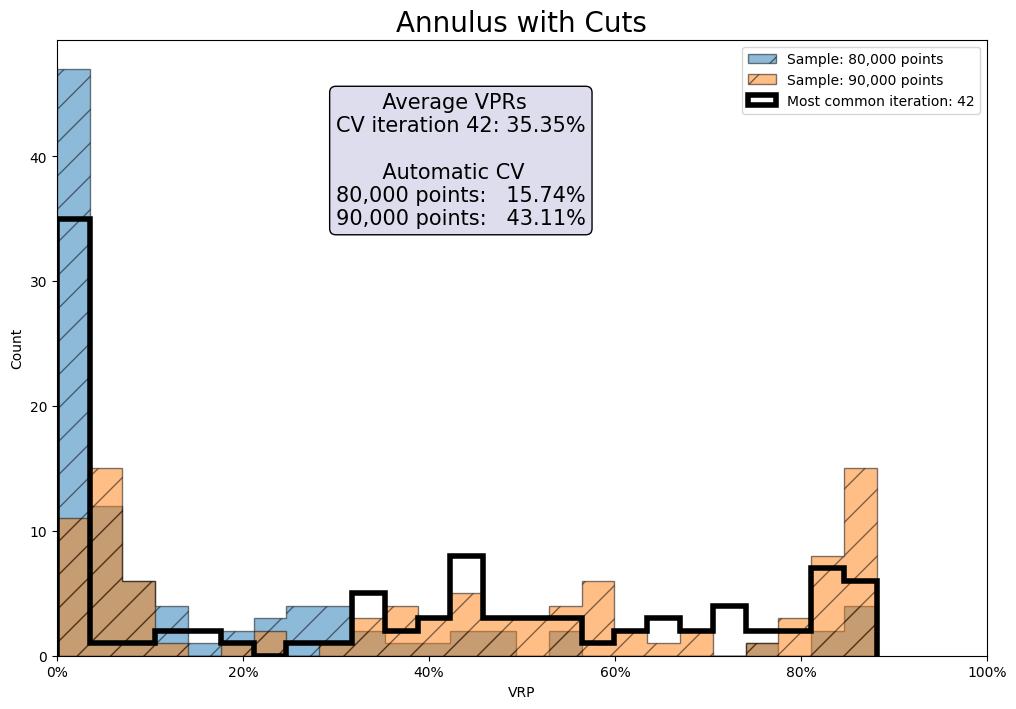

In [116]:
fig, ax = plt.subplots(figsize=(12, 8))
pointss = [80_000, 90_000]

auto_ys = [
    auto_vrpss[np.where(auto1_nevals == pointss[0])[0][0]]
    auto_vrpss[np.where(auto1_nevals == pointss[1])[0][0]]
]
max_ys = vrpss[:, most_common]

bins = np.histogram(np.hstack([*auto_ys, max_ys]), bins=25)[1]
for ind, ay in enumerate(auto_ys)):
    ax.hist(
        ay,
        histtype="stepfilled",
        hatch="/",
        alpha=0.5,
        ec="k",
        bins=bins,
        label=f"Sample: {pointss[ind]:,} points",
    )
ax.hist(
    max_ys,
    histtype="step",
    lw=4,
    # hatch="\\",
    # alpha=0.5,
    ec="k",
    bins=bins,
    label=f"Most common iteration: {1 + most_common}",
)
ax.set_xlim(0, 1)


text = (
    "       Average VPRs\n"
    f"CV iteration {1 + most_common}: {100 * avg_vrp:.2f}%"
)
for :
    text += f"\nAutomatic CV []:   {100 * np.mean(ay):.2f}%"
ax.annotate(
    text=text,
    xy=(0.3, 0.8),
    size=15,
    xycoords="axes fraction",
    bbox=dict(boxstyle="round", fc="#ddddee"),
)
ax.set_title(func.name, size=20)
ax.set_xlabel("VRP")
ax.set_ylabel("Count")
ax.xaxis.set_major_formatter(PercentFormatter(1.0))

ax.legend()


## Auto results for different number of points

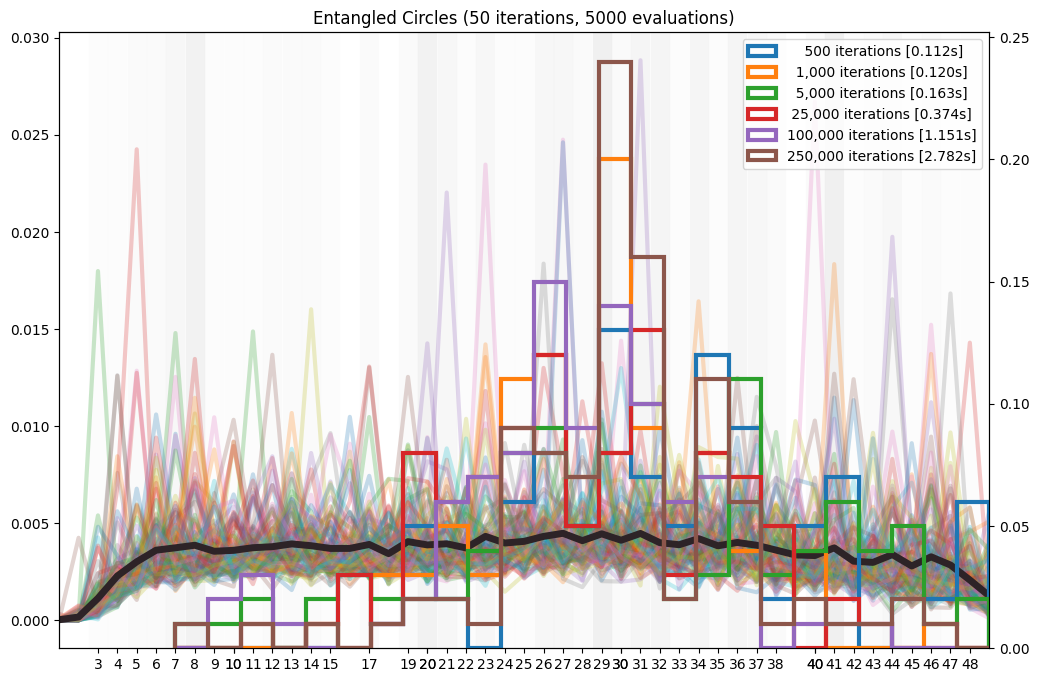

In [73]:
fig, ax = plt.subplots(figsize=(12, 8))

for vrps in vrpss:
    ax.plot(range(1, niters), vrps, alpha=0.25, lw=3)
ax.plot(range(1, niters), np.mean(vrpss, axis=0), lw=5, color="#2d2327")
vrp_maxes = Counter(np.argmax(vrpss, axis=1) + 1)
for max_ind, max_occurence in vrp_maxes.items():
    ax.axvline(max_ind, alpha=max_occurence / N, c="k", lw=14, zorder=-3)
ax.set_xticks(list(ax.get_xticks()) + list(vrp_maxes.keys()))

avg_times = np.mean(times, axis=1)
bins = np.histogram(np.hstack(chosen_cv_nitn), bins=25)[1]
ax2 = ax.twinx()
for ind in range(anevals):
    weights = np.ones_like(chosen_cv_nitn[ind]) / Na
    label = f"{auto1_nevals[ind]:>{1 + len(str(max(auto1_nevals)))},} point [{avg_times[ind]:.3f}s]"
    ax2.hist(
        chosen_cv_nitn[ind],
        weights=weights,
        bins=bins,
        lw=3,
        histtype="step",
        label=label,
    )

ax.set_title(f"{func.name} ({niters} iterations, {nevals} evaluations)")
ax.set_xlim(1, niters - 1)
ax2.legend()


## Timing

In [3]:
cvi = CVITime(
    function=NPolynomial(96), evals=2 * nevals, tot_iters=1.0 * niters, cv_iters=None
)
cvi.TIMING = True
print(f"Number of CVs: {len(cvi.cv_nitn)}")
cvi.integrate()
print(cvi.w_stdev)


Number of CVs: 0
   1: create_maps --------------------------------------- 2.402s
   2: get_is_cv_values ---------------------------------- 0.964s
     Make hypercube ------------------------------- 0.299s
     Find IS map ---------------------------------- 0.477s
     Find vegas values ---------------------------- 0.186s
     Find CV values ------------------------------- 0.000s
   3: garbage_collect ----------------------------------- 0.002s
   4: integrate ----------------------------------------- 3.369s
0.0007266256860840183


In [4]:
cvi = CVITime(function=ScalarTopLoop(), evals=nevals, tot_iters=niters, cv_iters=23)
print(f"Number of CVs: {len(cvi.cv_nitn)}")
cvi.integrate()
print(cvi.stdev)


Number of CVs: 1
   1: create_maps --------------------------------------- 0.069s
     First iteration ------------------------------ 0.030s
     First deepcopy ------------------------------- 0.001s
     Other iterations/deepcopies ------------------ 0.000s
     Last iteration ------------------------------- 0.037s
     Last deepcopy -------------------------------- 0.001s
   2: get_is_cv_values ---------------------------------- 0.090s
     Make hypercube ------------------------------- 0.005s
     Find IS map ---------------------------------- 0.006s
     Find vegas values ---------------------------- 0.032s
     Find CV values ------------------------------- 0.047s
   3: get_weight_prime ---------------------------------- 0.005s
     Find coefficient(s) -------------------------- 0.004s
       Build B ------------------------------------ 0.002s
       Build A ------------------------------------ 0.002s
       Solve inverse ------------------------------ 0.000s
     Calculate final 

In [47]:
cvi = CVITime(function=ScalarTopLoop(), evals=nevals, tot_iters=niters, cv_iters="all")
print(f"Number of CVs: {len(cvi.cv_nitn)}")
cvi.integrate()


Number of CVs: 49
   1: create_maps --------------------------------------- 0.126s
     First iteration ------------------------------ 0.006s
     First deepcopy ------------------------------- 0.002s
     Other iterations/deepcopies ------------------ 0.116s
     Last iteration ------------------------------- 0.002s
     Last deepcopy -------------------------------- 0.001s
   2: get_is_cv_values ---------------------------------- 2.000s
     Make hypercube ------------------------------- 0.004s
     Find IS map ---------------------------------- 0.005s
     Find vegas values ---------------------------- 0.027s
     Find CV values ------------------------------- 1.963s
   3: get_weight_prime ---------------------------------- 0.289s
     Find coefficient(s) -------------------------- 0.190s
       Build B ------------------------------------ 0.092s
       Build A ------------------------------------ 0.097s
       Solve inverse ------------------------------ 0.000s
     Calculate final

In [50]:
cvi = CVITime(function=ScalarTopLoop(), evals=nevals, tot_iters=niters, cv_iters="all")
print(f"Number of CVs: {len(cvi.cv_nitn)}")
cvi.integrate(constant=False)


Number of CVs: 49
   1: create_maps --------------------------------------- 0.131s
     First iteration ------------------------------ 0.005s
     First deepcopy ------------------------------- 0.002s
     Other iterations/deepcopies ------------------ 0.121s
     Last iteration ------------------------------- 0.002s
     Last deepcopy -------------------------------- 0.001s
   2: get_is_cv_values ---------------------------------- 2.054s
     Make hypercube ------------------------------- 0.004s
     Find IS map ---------------------------------- 0.005s
     Find vegas values ---------------------------- 0.028s
     Find CV values ------------------------------- 2.017s
   3: get_weight_prime ---------------------------------- 39.924s
     Find coefficient(s) -------------------------- 39.781s
       Build B ------------------------------------ 6.520s
       Build A ------------------------------------ 0.212s
       Solve inverse ------------------------------ 32.868s
     Calculate fi

---

In [7]:
cvi = CVIntegrator(
    function=NGauss(2), evals=nevals, tot_iters=niters, cv_iters="all%2", memory="max"
)
cvi.integrate()
cvi.compare(rounding=6)


(24, 24)
(24,)
         |    No CVs    |   With CVs   
---------+--------------+--------------
Mean     |     0.999224 |     0.999244
Variance | 1.120588e-08 | 6.277239e-09
St Dev   | 1.058578e-04 | 7.922903e-05
VRP      |              |   43.982628%


In [5]:
cvi.Bs.shape, cvi.As.shape


((99, 99), (99,))

In [52]:
%timeit [np.cov(cvi.weight_value, cv_value)[0, 1] for cv_value in cvi.cv_values]

10.5 s ± 3.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
%timeit np.cov(cvi.weight_value, cvi.cv_values)[0, 1:]

7.5 s ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


10,000 iters and 100,000 jac_nevals give 6.4s for long and 25.7s for short

100 iters and 10,000,000 jac_nevals gives 10.5s for long and 7.5 for short

In [69]:
cvi2 = CVIntegrator(function=NGauss(2), evals=nevals, tot_iters=niters, cv_iters="all")
cvi2.integrate(constant=False)
cvi2.compare(rounding=6)


         |    No CVs    |   With CVs   
---------+--------------+--------------
Mean     |     0.999165 |     0.999214
Variance | 1.094703e-08 | 6.244586e-09
St Dev   | 1.046281e-04 | 7.902269e-05
VRP      |              |   42.956349%


In [74]:
cvi3 = CVIntegrator(
    function=NGauss(2), evals=nevals, tot_iters=niters, cv_iters="auto1"
)
cvi3.integrate(constant=True, auto1_neval=100_000)
cvi3.compare(rounding=6)


         |    No CV     |   With CV    
---------+--------------+--------------
Mean     |     0.999214 |     0.999237
Variance | 1.110270e-08 | 9.098165e-09
St Dev   | 1.053694e-04 | 9.538430e-05
VRP      |              |   18.054483%


In [76]:
cvi4 = CVIntegrator(
    function=NGauss(2), evals=nevals, tot_iters=niters, cv_iters="auto1"
)
cvi4.integrate(constant=False, auto1_neval=100_000)
cvi4.compare(rounding=6)


         |    No CV     |   With CV    
---------+--------------+--------------
Mean     |     0.999116 |     0.999063
Variance | 1.170935e-08 | 9.433228e-09
St Dev   | 1.082098e-04 | 9.712481e-05
VRP      |              |   19.438510%


In [108]:
cvi.As


array([ 3.22236526e-02,  2.07376974e-02,  1.30367102e-02,  7.73852079e-03,
        4.36350512e-03,  2.13777008e-03,  6.60566828e-04, -1.76354244e-04,
       -7.92325865e-04, -8.81925018e-04, -1.30148479e-03, -1.31803115e-03,
       -1.08354943e-03, -1.32772273e-03, -1.48943238e-03, -1.49324855e-03,
       -1.54776181e-03, -1.56161812e-03, -1.58303089e-03, -1.52021440e-03,
       -1.46464572e-03, -1.37057449e-03, -1.28291538e-03, -1.14709588e-03,
       -9.90610357e-04, -9.15948982e-04, -7.70524762e-04, -5.87444750e-04,
       -5.05788045e-04, -4.88620430e-04, -3.99305886e-04, -3.65111574e-04,
       -3.77635555e-04, -3.63459374e-04, -3.24846284e-04, -3.02326413e-04,
       -3.09332783e-04, -2.56578612e-04, -2.64286282e-04, -2.68269319e-04,
       -3.20619953e-04, -2.91713021e-04, -1.91448717e-04, -1.09022276e-04,
       -1.49993240e-04, -8.47803453e-05, -8.50878391e-05, -7.98385136e-05,
       -5.61856730e-05])

In [110]:
-np.cov(cvi.weight_value, cvi.cv_values)[0, 1:] == cvi.As


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [111]:
np.array(
    [-np.cov(cvi.weight_value, cv_value)[0, 1] for cv_value in cvi.cv_values]
) == cvi.As


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])